# Project 3, Part 3
- Martisha Owens
- 12/9/2022

## Imports

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os, time, json
import tmdbsimple as tmdb 
from tqdm.notebook import tqdm_notebook

import pymysql
pymysql.install_as_MySQLdb()
from sqlalchemy import create_engine
from sqlalchemy_utils import create_database, database_exists

import scipy.stats as stats

In [21]:
with open('/Users/martishaowens/.secret/tmdb_api.json', 'r') as f:
    login = json.load(f)
login.keys()
tmdb.API_KEY =  login['api-key']

## Define Functions

In [13]:
def get_movie_with_rating(movie_id):
    movie = tmdb.Movies(movie_id)
    
    info = movie.info()
    
    releases = movie.releases()
    
    for c in releases['countries']:
        if c['iso_3166_1' ] =='US':
            info['certification'] = c['certification']
    return info

In [14]:
def write_json(new_data, filename): 
    """Appends a list of records (new_data) to a json file (filename). """
    
    with open(filename,'r+') as file:
        file_data = json.load(file)
        if (type(new_data) == list) & (type(file_data) == list):
            file_data.extend(new_data)
        else:
             file_data.append(new_data)
        file.seek(0)
        json.dump(file_data, file)

## API Loop

In [22]:
basics = pd.read_csv('data/title_basics.csv.gz')
basics.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,runtimeMinutes,genres
0,tt0035423,movie,Kate & Leopold,Kate & Leopold,0,2001,118,"Comedy,Fantasy,Romance"
1,tt0062336,movie,The Tango of the Widower and Its Distorting Mi...,El Tango del Viudo y Su Espejo Deformante,0,2020,70,Drama
2,tt0069049,movie,The Other Side of the Wind,The Other Side of the Wind,0,2018,122,Drama
3,tt0088751,movie,The Naked Monster,The Naked Monster,0,2005,100,"Comedy,Horror,Sci-Fi"
4,tt0096056,movie,Crime and Punishment,Crime and Punishment,0,2002,126,Drama


In [34]:
YEARS_TO_GET = [2020,2011]
errors = [ ]
FOLDER = "Data/"

for YEAR in tqdm_notebook(YEARS_TO_GET, desc='YEARS', position=0):
    JSON_FILE = f'{FOLDER}tmdb_api_results_{YEAR}.json'
    file_exists = os.path.isfile(JSON_FILE)
    
    if file_exists == False:
        with open(JSON_FILE,'w') as f:
            json.dump([{'imdb_id':0}],f)
    df = basics.loc[ basics['startYear']==YEAR].copy()
    movie_ids = df['tconst'].copy()     
    
    previous_df = pd.read_json(JSON_FILE)
    movie_ids_to_get = movie_ids[~movie_ids.isin(previous_df['imdb_id'])]
    
    for movie_id in tqdm_notebook(movie_ids_to_get,
                                  desc=f'Movies from {YEAR}',
                                  position=1,
                                  leave=True):
        try:
            temp = get_movie_with_rating(movie_id)  
            write_json(temp,JSON_FILE)
            time.sleep(0.02)
            
        except Exception as e:
            errors.append([movie_id, e])
            
    final_year_df = pd.read_json(JSON_FILE)
    final_year_df.to_csv(f"{FOLDER}final_tmdb_data_{YEAR}.csv.gz", compression="gzip", index=False)

print(f"- Total errors: {len(errors)}")

YEARS:   0%|          | 0/1 [00:00<?, ?it/s]

Movies from 2011:   0%|          | 0/4158 [00:00<?, ?it/s]

- Total errors: 1233


# Questions to Answer

In [6]:
filename = 'Data/tmdb_results_combined.csv.gz'
df = pd.read_csv(filename)
df.head(3)

,imdb_id,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,original_language,original_title,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,certification
0,tt0113026,0.0,/vMFs7nw6P0bIV1jDsQpxAieAVnH.jpg,NaN,10000000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10402, '...",NaN,62127.0,en,The Fantasticks,...,0.0,86.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Try to remember the first time magic happened,The Fantasticks,0.0,5.500,22.0,NaN
1,tt0118694,0.0,/n4GJFGzsc7NinI1VeGDXIcQjtU2.jpg,NaN,150000.0,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",http://www.wkw-inthemoodforlove.com/,843.0,cn,花樣年華,...,12854953.0,99.0,"[{'english_name': 'Cantonese', 'iso_639_1': 'c...",Released,"Feel the heat, keep the feeling burning, let t...",In the Mood for Love,0.0,8.104,2027.0,PG
2,tt0119273,0.0,/f5C03doOWiauu37bToKXtpgP5bS.jpg,"{'id': 141086, 'name': 'Heavy Metal Collection...",15000000.0,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",NaN,16225.0,en,Heavy Metal 2000,...,0.0,88.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,not to survive the fight in the external world...,Heavy Metal 2000,0.0,6.088,164.0,R


In [9]:
dfc = df[(df['budget']>0)|(df['revenue']>0)]
dfc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 625 entries, 0 to 624
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   imdb_id                625 non-null    object 
 1   adult                  625 non-null    float64
 2   backdrop_path          524 non-null    object 
 3   belongs_to_collection  103 non-null    object 
 4   budget                 625 non-null    float64
 5   genres                 625 non-null    object 
 6   homepage               80 non-null     object 
 7   id                     625 non-null    float64
 8   original_language      625 non-null    object 
 9   original_title         625 non-null    object 
 10  overview               622 non-null    object 
 11  popularity             625 non-null    float64
 12  poster_path            603 non-null    object 
 13  production_companies   625 non-null    object 
 14  production_countries   625 non-null    object 
 15  releas

In [39]:
dfc.dropna(subset = ['certification'],inplace = True)

## 1. Does the MPAA rating of a movie (G/PG/PG-13/R) affect how much revenue the movie generates?

- Null Hypothesis: Movie certification does not affect the amount of revenue is made.
- Alt. Hypothesis: Movie certification has an affect on the amount of revenue made.
- Test: ANOVA Testing, has more than two groups

In [40]:
groups = {}

for i in dfc['certification'].unique():
    data = dfc.loc[dfc['certification']==i,'revenue'].copy()
    
    groups[i] = data

groups.keys()

dict_keys(['PG', 'R', 'G', 'PG-13', 'NR'])

### Visualization

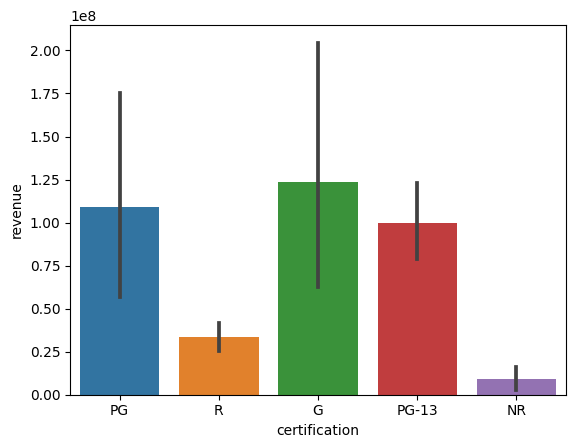

In [41]:
sns.barplot(data=dfc, x='certification',y='revenue');

### Test for Outliers

In [42]:
outlier_results = {}
for i, data in groups.items():
    zscores = stats.zscore(groups[i])
    outliers = abs(zscores)>3
    outlier_results[i] = {np.sum(outliers)}
    
outlier_results

{'PG': {1}, 'R': {5}, 'G': {1}, 'PG-13': {2}, 'NR': {0}}

In [43]:
#All of the groups have outliers

for i,data in groups.items():
    groups[i] = groups[i][(np.abs(stats.zscore(groups[i])) < 3)]

### Test for Normality

In [44]:
norm_results = {}
for i, data in groups.items():
    stat, p = stats.normaltest(data)
    norm_results[i] = {'n': len(data),
                             'p':p,
                             'test stat':stat,}
norm_results_df = pd.DataFrame(norm_results).T
norm_results_df

/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1477: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1477: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


,n,p,test stat
PG,35.0,4.377549e-06,24.678043
R,223.0,6.248450e-25,111.464588
G,13.0,3.648793e-01,2.016377
PG-13,128.0,1.320751e-10,45.495300
NR,17.0,7.935049e-03,9.672931


In [45]:
norm_results_df['sig'] = norm_results_df['p'] < .05 
norm_results_df
#Each group, except for G rated movies, did not have a normal distribution but the sample size is big enough

,n,p,test stat,sig
PG,35.0,4.377549e-06,24.678043,True
R,223.0,6.248450e-25,111.464588,True
G,13.0,3.648793e-01,2.016377,False
PG-13,128.0,1.320751e-10,45.495300,True
NR,17.0,7.935049e-03,9.672931,True


### Test for Equal Variance

In [46]:
stats.levene( *groups.values())
#Failed the assumption of equal variance, need to include equal_var=False

LeveneResult(statistic=13.107279572526956, pvalue=4.673188465733158e-10)

### Perform ANOVA Testing

In [47]:
result = stats.f_oneway( *groups.values())
result
#Failed to reject the Null Hypothesis and accepted the Alt. Hypothesis.

F_onewayResult(statistic=16.794302386147013, pvalue=9.209039653012378e-13)

In [49]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

values = dfc['revenue']
labels = dfc['certification']

tukeys_results = pairwise_tukeyhsd(values,labels)
tukeys_results.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
G,NR,-114858656.0462,0.0267,-221134249.2123,-8583062.8801,True
G,PG,-14527879.9841,0.9929,-107277236.0639,78221476.0956,False
G,PG-13,-23719722.7593,0.935,-106549543.465,59110097.9463,False
G,R,-90393342.161,0.0202,-171474027.4892,-9312656.8328,True
NR,PG,100330776.0621,0.014,13673827.354,186987724.7701,True
NR,PG-13,91138933.2869,0.0096,15193144.0401,167084722.5336,True
NR,R,24465313.8852,0.8948,-49568875.7806,98499503.551,False
PG,PG-13,-9191842.7752,0.9912,-64650874.9946,46267189.4442,False
PG,R,-75865462.1769,0.0009,-128676470.4032,-23054453.9506,True
PG-13,R,-66673619.4017,0.0,-99036232.6275,-34311006.1759,True


- In conclusion, we failed to reject the Null Hypothesis and accepted the Alt. Hypothesis.
- R Rated movies in comparison to G, PG, and PG-13 had quite a big affect and based on the visualization above it is clear that R-rated movies had lower revenue.

## 2. Do movies that are  2 hours or longer earn more revenue than movies that are less than 2 hours long.

- Null Hypothesis: Movie length does not affect the amount of revenue made.
- Alt. Hypothesis: The length of the movie certification has an affect on the amount of revenue made.
- Test: 2 sample T-test, long and short movie

In [63]:
dfc['running'] = dfc['runtime']>=120
long_rev = dfc.loc[dfc['runtime']>=120,'revenue']
short_rev = dfc.loc[dfc['runtime']<120,'revenue']

In [69]:
dfc['running'].value_counts()

False    345
True      80
Name: running, dtype: int64

### Visualization

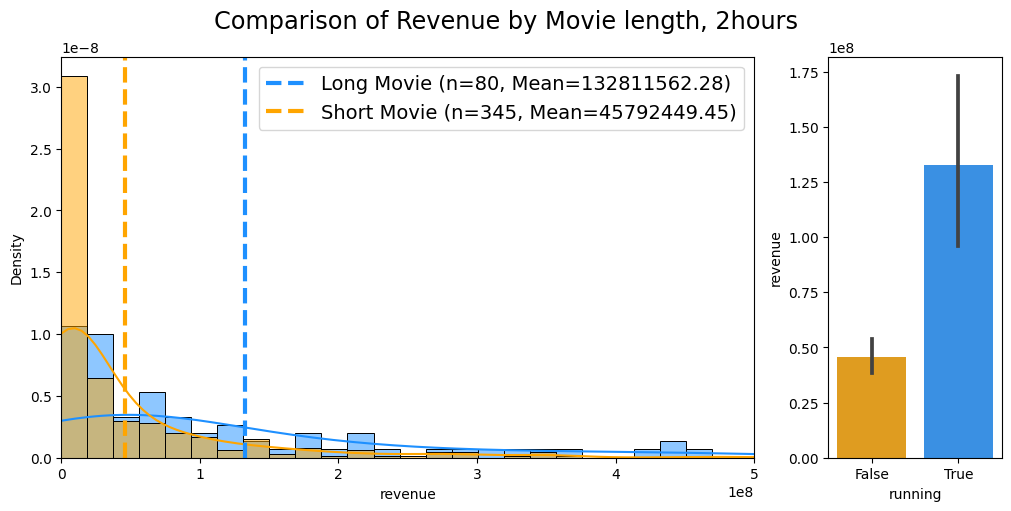

In [79]:
movie_palette={True:'dodgerblue', False:'orange'}

## Visualizing Sample means
fig, (ax,ax_bar) = plt.subplots(figsize= (10,5), ncols=2, 
                                constrained_layout=True,
                                gridspec_kw={'width_ratios':[0.8,0.2]})


# Histogram
ax = sns.histplot(data=dfc[['running','revenue']], x='revenue',fill=True,hue='running',kde=True,
                  stat='density',common_norm=False,ax=ax,
                  palette=movie_palette)
 
ax.axvline(np.mean(long_rev), ls='--',lw=3, 
           label=f"Long Movie (n={len(long_rev)}, Mean={np.mean(long_rev):.2f})",color=movie_palette[True])

ax.axvline(np.mean(short_rev), ls='--', lw=3, 
           label=f"Short Movie (n={len(short_rev)}, Mean={np.mean(short_rev):.2f})",color=movie_palette[False])
ax.set_xlim([0, 500000000])
ax.legend(prop={"size":14}, loc='upper right')

## Barplot
sns.barplot(data=dfc[['running','revenue']], x='running',y='revenue',ax = ax_bar,palette=movie_palette)
fig.suptitle('Comparison of Revenue by Movie length, 2hours',fontsize='xx-large');

### Test for Outliers

In [80]:
zscores_s = stats.zscore(long_rev)
outliers_s = abs(zscores_s)>3
np.sum(outliers_s)

2

In [81]:
long_rev = long_rev[(np.abs(stats.zscore(long_rev)) < 3)]

In [82]:
zscores_s = stats.zscore(short_rev)
outliers_s = abs(zscores_s)>3
np.sum(outliers_s)

9

In [83]:
short_rev = short_rev[(np.abs(stats.zscore(short_rev)) < 3)]

### Test for Normality

In [84]:
stats.normaltest(long_rev)
#Long Movie Group is not normal, but the sample size is greater than 15, so will proceed

NormaltestResult(statistic=27.621635593469293, pvalue=1.0047037894778373e-06)

In [85]:
stats.normaltest(short_rev)
#Short Movie Group is not normal, but the sample size is greater than 15, so will proceed

NormaltestResult(statistic=163.7973772877588, pvalue=2.703033616371091e-36)

### Test for Equal Variance

In [86]:
stats.levene(long_rev,short_rev)
#Failed the assumption of equal variance, need to include equal_var=False

LeveneResult(statistic=42.56752584579897, pvalue=2.0064176493952136e-10)

### Perform T-Test

In [87]:
result = stats.ttest_ind(long_rev,short_rev,equal_var = False)
result.pvalue < .05
#Fail to reject Null, Accept Alt

True

- In conclusion, we failed to reject the Null Hypothesis and accepted the Alt. Hypothesis.
- Movie length does affect the revenue made. Movies that are 2hrs or longer made greater revenue

## 3. Are budgets greater for movies made in 2010 than in 2000.

- Null Hypothesis: Movie budgets have remained the same over the years.
- Alt. Hypothesis: Movie budgets have increased in the newer years
- Test: 2 sample T-test, old and new movie

In [88]:
tmdb2000 = pd.read_csv('data/final_tmdb_data_2000.csv.gz')
tmdb2010 = pd.read_csv('data/final_tmdb_data_2010.csv.gz')
tmdb2010.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2626 entries, 0 to 2625
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   imdb_id                2626 non-null   object 
 1   adult                  2625 non-null   float64
 2   backdrop_path          1377 non-null   object 
 3   belongs_to_collection  184 non-null    object 
 4   budget                 2625 non-null   float64
 5   genres                 2625 non-null   object 
 6   homepage               800 non-null    object 
 7   id                     2625 non-null   float64
 8   original_language      2625 non-null   object 
 9   original_title         2625 non-null   object 
 10  overview               2544 non-null   object 
 11  popularity             2625 non-null   float64
 12  poster_path            2228 non-null   object 
 13  production_companies   2625 non-null   object 
 14  production_countries   2625 non-null   object 
 15  rele

In [92]:
tmdb2000['Year'] = 2000
tmdb2010['Year'] = 2010

In [93]:
dfb = pd.concat([tmdb2000, tmdb2010], ignore_index=True)
dfb.head()

,imdb_id,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,original_language,original_title,...,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,certification,Year
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000
1,tt0113026,0.0,/vMFs7nw6P0bIV1jDsQpxAieAVnH.jpg,NaN,10000000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10402, '...",NaN,62127.0,en,The Fantasticks,...,86.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Try to remember the first time magic happened,The Fantasticks,0.0,5.500,22.0,NaN,2000
2,tt0113092,0.0,NaN,NaN,0.0,"[{'id': 878, 'name': 'Science Fiction'}]",NaN,110977.0,en,For the Cause,...,100.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,The ultimate showdown on a forbidden planet.,For the Cause,0.0,5.100,8.0,NaN,2000
3,tt0116391,0.0,NaN,NaN,0.0,"[{'id': 18, 'name': 'Drama'}, {'id': 28, 'name...",NaN,442869.0,hi,Gang,...,152.0,"[{'english_name': 'Hindi', 'iso_639_1': 'hi', ...",Released,NaN,Gang,0.0,4.000,1.0,NaN,2000
4,tt0118694,0.0,/n4GJFGzsc7NinI1VeGDXIcQjtU2.jpg,NaN,150000.0,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",http://www.wkw-inthemoodforlove.com/,843.0,cn,花樣年華,...,99.0,"[{'english_name': 'Cantonese', 'iso_639_1': 'c...",Released,"Feel the heat, keep the feeling burning, let t...",In the Mood for Love,0.0,8.104,2027.0,PG,2000


In [95]:
dfb['Year'].unique()

array([2000, 2010])

In [96]:
dfb = dfb[(dfb['budget']>0)|(dfb['revenue']>0)]
dfb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 999 entries, 1 to 3833
Data columns (total 27 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   imdb_id                999 non-null    object 
 1   adult                  999 non-null    float64
 2   backdrop_path          782 non-null    object 
 3   belongs_to_collection  148 non-null    object 
 4   budget                 999 non-null    float64
 5   genres                 999 non-null    object 
 6   homepage               393 non-null    object 
 7   id                     999 non-null    float64
 8   original_language      999 non-null    object 
 9   original_title         999 non-null    object 
 10  overview               991 non-null    object 
 11  popularity             999 non-null    float64
 12  poster_path            951 non-null    object 
 13  production_companies   999 non-null    object 
 14  production_countries   999 non-null    object 
 15  relea

In [104]:
bud2000 = dfb.loc[dfb['Year']==2000,'budget']
bud2010 = dfb.loc[dfb['Year']==2010,'budget']

In [105]:
dfb['Year'].value_counts()

2010    705
2000    294
Name: Year, dtype: int64

### Visualization

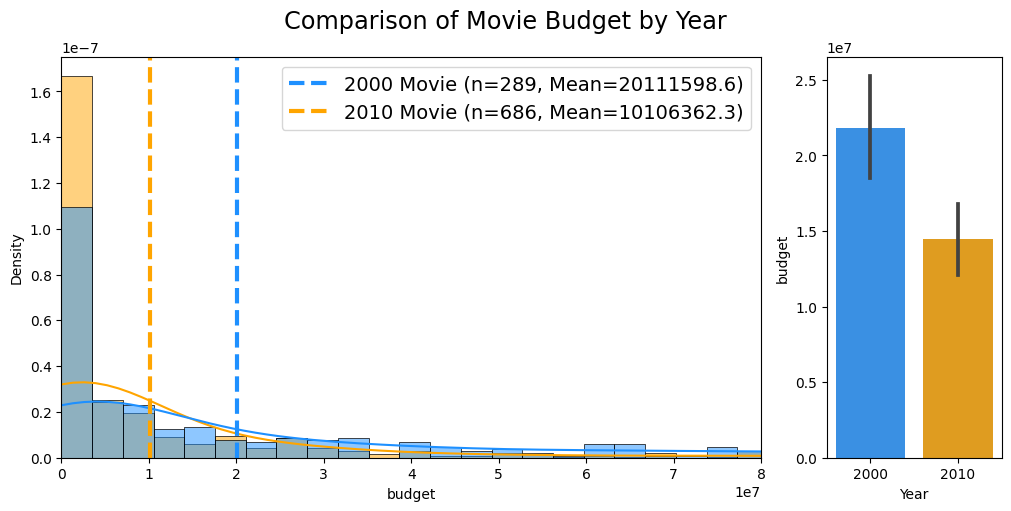

In [124]:
movie_palette={2000:'dodgerblue', 2010:'orange'}

## Visualizing Sample means
fig, (ax,ax_bar) = plt.subplots(figsize= (10,5), ncols=2, 
                                constrained_layout=True,
                                gridspec_kw={'width_ratios':[0.8,0.2]})


# Histogram
ax = sns.histplot(data=dfb[['Year','budget']], x='budget',fill=True,hue='Year',kde=True,
                  stat='density',common_norm=False,ax=ax,
                  palette=movie_palette)
 
ax.axvline(np.mean(bud2000), ls='--',lw=3, 
           label=f"2000 Movie (n={len(bud2000)}, Mean={np.mean(bud2000):.1f})",color=movie_palette[2000])

ax.axvline(np.mean(bud2010), ls='--', lw=3, 
           label=f"2010 Movie (n={len(bud2010)}, Mean={np.mean(bud2010):.1f})",color=movie_palette[2010])
ax.set_xlim([0, 80000000])
ax.legend(prop={"size":14}, loc='upper right')

## Barplot
sns.barplot(data=dfb[['Year','budget']], x='Year',y='budget',ax = ax_bar,palette=movie_palette)
fig.suptitle('Comparison of Movie Budget by Year',fontsize='xx-large');

### Test for Outliers

In [110]:
zscores_s = stats.zscore(bud2000)
outliers_s = abs(zscores_s)>3
np.sum(outliers_s)

5

In [111]:
bud2000 = bud2000[(np.abs(stats.zscore(bud2000)) < 3)]

In [112]:
zscores_s = stats.zscore(bud2010)
outliers_s = abs(zscores_s)>3
np.sum(outliers_s)

19

In [113]:
bud2010 = bud2010[(np.abs(stats.zscore(bud2010)) < 3)]

### Test for Normality

In [114]:
stats.normaltest(bud2000)
#2000 Movie Group is not normal, but the sample size is greater than 15, so will proceed

NormaltestResult(statistic=71.26916000869625, pvalue=3.3427087575519074e-16)

In [115]:
stats.normaltest(bud2010)
#2010 Movie Group is not normal, but the sample size is greater than 15, so will proceed

NormaltestResult(statistic=441.5596036912111, pvalue=1.3078271314788293e-96)

### Test for Equal Variance

In [116]:
stats.levene(bud2000,bud2010)
#Failed the assumption of equal variance, need to include equal_var=False

LeveneResult(statistic=37.0614174117595, pvalue=1.6450875991722553e-09)

### Perform T-Test

In [120]:
result = stats.ttest_ind(bud2000,bud2010,equal_var = False)
print(f'{result.pvalue < .05}, {result.pvalue}')
#Fail to reject Null, Accept Alt

True, 1.070855342577773e-08


- In conclusion, we failed to reject the Null Hypothesis and accepted the Alt. Hypothesis.
- Movies made in 2010 have a greater budget than movies from 2000
- This shift is compared to the visual is due to removing outliers.